# Experiment 6.3. Dependence of the perturbation on $q$

In [1]:
import torch, torchvision
import method
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from skimage.io import imread
from skimage.transform import resize
import os
from PIL import Image

In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])

In [4]:
def get_batch(valdir, batch_size):
    img_batch = []
    filenames = os.listdir(valdir)
    for fn in filenames[:batch_size]:
        img = Image.open(valdir + fn)
        img = transform(img)
        img = normalize(img)
        img_batch.append(img.numpy())
        
    img_batch = np.array(img_batch)
    
    return img_batch

In [5]:
def get_output_size(model, layer_num, device):
    x = torch.randn(1, 3, 224, 224).to(device)
    hidden_size = model.feature(x, layer_num).shape[0]
    return hidden_size

In [6]:
def compute_sing_vals_vecs(Adot, ATdot, p, q_grid, max_iter):
    q_sing_vals = []
    q_sing_vecs = []
    x0 = ((np.random.rand(3 * 224**2) - 0.5)/ 255.).astype(np.float64)
    for q in tqdm(q_grid):
        x, s = method.power_method(np.copy(x0), Adot, ATdot, p=p, q=q, max_iter=max_iter)
        q_sing_vals.append((q, s))
        q_sing_vecs.append((q, x))
    return q_sing_vals, q_sing_vecs

In [7]:
def plot_sing_vals(q_sing_vals):
    for q, val in q_sing_vals:
        plt.scatter(q, np.log(val))
    plt.grid()
    plt.xlabel('q')
    plt.ylabel('Logarithm Singular value')
    plt.title('Singular values for different $q$')
    plt.show()

In [8]:
def plot_sing_vecs(q_sing_vecs, path):
    # q_sing_vecs is assumed to be grid of size 20
    fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
    for i, (q, vec) in enumerate(q_sing_vecs):
        adv = vec.reshape(3, 224, 224) * 10. / 255.
        adv1 = (adv - adv.min())/(adv.max() - adv.min())
        ax[i//4, i % 4].imshow(adv1.transpose((1, 2, 0)))
        ax[i//4, i % 4].set_title('q = ' + str(np.round(q, decimals=1)))
    fig.tight_layout()
    plt.savefig(path + 'adv.png')
    plt.show()

In [9]:
def compute_fooling_rates(net, advs, device, valdir):
    filenames = os.listdir(valdir)
    batch_size = 128
    n_steps = len(filenames) // batch_size + 1
    counters = {}
    for j, q in enumerate(advs):
        counters[q] = 0.
        adv = advs[q]
        counter_bad = 0.
        net.eval()
        for i in tqdm(range(n_steps)):
            fn_batch = filenames[i * batch_size : (i + 1) * batch_size]
            cur_batch = []
            cur_batch_pert = []
            for fn in fn_batch:
                cur_img = Image.open(valdir + fn)

                if np.array(cur_img).ndim != 3 or np.array(cur_img).shape[-1] != 3:
                    counter_bad += 1
                    continue

                cur_img = transform(cur_img)
                cur_img_pert = cur_img + adv

                cur_img = normalize(cur_img)
                cur_img_pert = normalize(cur_img_pert)     

                cur_batch.append(cur_img)
                cur_batch_pert.append(cur_img_pert)

            img_batch_tensor = torch.stack(cur_batch).to(device)
            p = method.tonp(net(img_batch_tensor))
            img_batch_pert_tensor = torch.stack(cur_batch_pert).to(device)
            p_pert = method.tonp(net(img_batch_pert_tensor))
            counters[q] += np.sum(p.argmax(1) != p_pert.argmax(1))
            
    fooling_rates = {}
    for q in counters:
        c = counters[q]
        fooling_rates[q] = c / (len(filenames) - counter_bad)
        
    return fooling_rates

In [10]:
def plot_fooling_rates(fooling_rates, path):
    q = list(fooling_rates.keys())
    f_rates = list(fooling_rates.values())
    plt.plot(q, f_rates)
    plt.xlabel('q')
    plt.ylabel('Fooling rate')
    plt.grid()
    plt.title('Dependence of the fooling rate on the value of $q$')
    plt.savefig(path + 'f_rate.png')
    plt.show()

In [11]:
def make_exp(net_type, device, layer_num, path):
    valdir = './imnet/'
    max_iter = 30
    p = np.inf
    # define model
    # net type: vgg16, vgg19 or resnet50
    if net_type == 'vgg16':
        net = torchvision.models.vgg16(pretrained=True)
        net.to(device)
        net.eval()
        model = method.VGGWrapper(net, device)
    elif net_type == 'vgg19':
        net = torchvision.models.vgg19(pretrained=True)
        net.to(device)
        net.eval()
        model = method.VGGWrapper(net, device)
    elif net_type == 'resnet50':
        net = torchvision.models.resnet50(pretrained=True)
        net.to(device)
        net.eval()
        model = method.ResNetWrapper(net, device)
    
    # compute singluar values and vectors
    img_batch = get_batch(valdir, batch_size=64)
    hidden_size = get_output_size(model, layer_num, device)
    Adot, ATdot = method.get_batched_matvec(img_batch, model, layer_num, hidden_size)
    q_grid = np.linspace(1, 10, 20)
    q_sing_vals, q_sing_vecs = compute_sing_vals_vecs(Adot, ATdot, p, q_grid, max_iter)
    
    # plot singular values, singular vector, perturbed image
    plot_sing_vals(q_sing_vals)
    plot_sing_vecs(q_sing_vecs, path)
    
    # make adversarials
    advs = {}
    for (q, vec) in q_sing_vecs:
        advs[q] = torch.FloatTensor(vec.reshape(3, 224, 224) * 10. / 255.)
    
    # compute fooling rates
    fooling_rates = compute_fooling_rates(net, advs, device, valdir)
    
    # plot fooling rate
    plot_fooling_rates(fooling_rates, path)

# VGG19 block2_pool

100%|██████████| 20/20 [47:19<00:00, 134.77s/it]


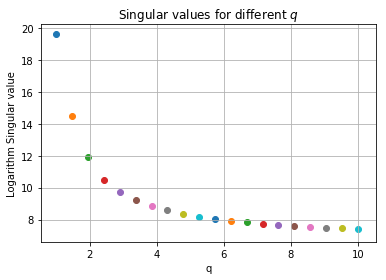

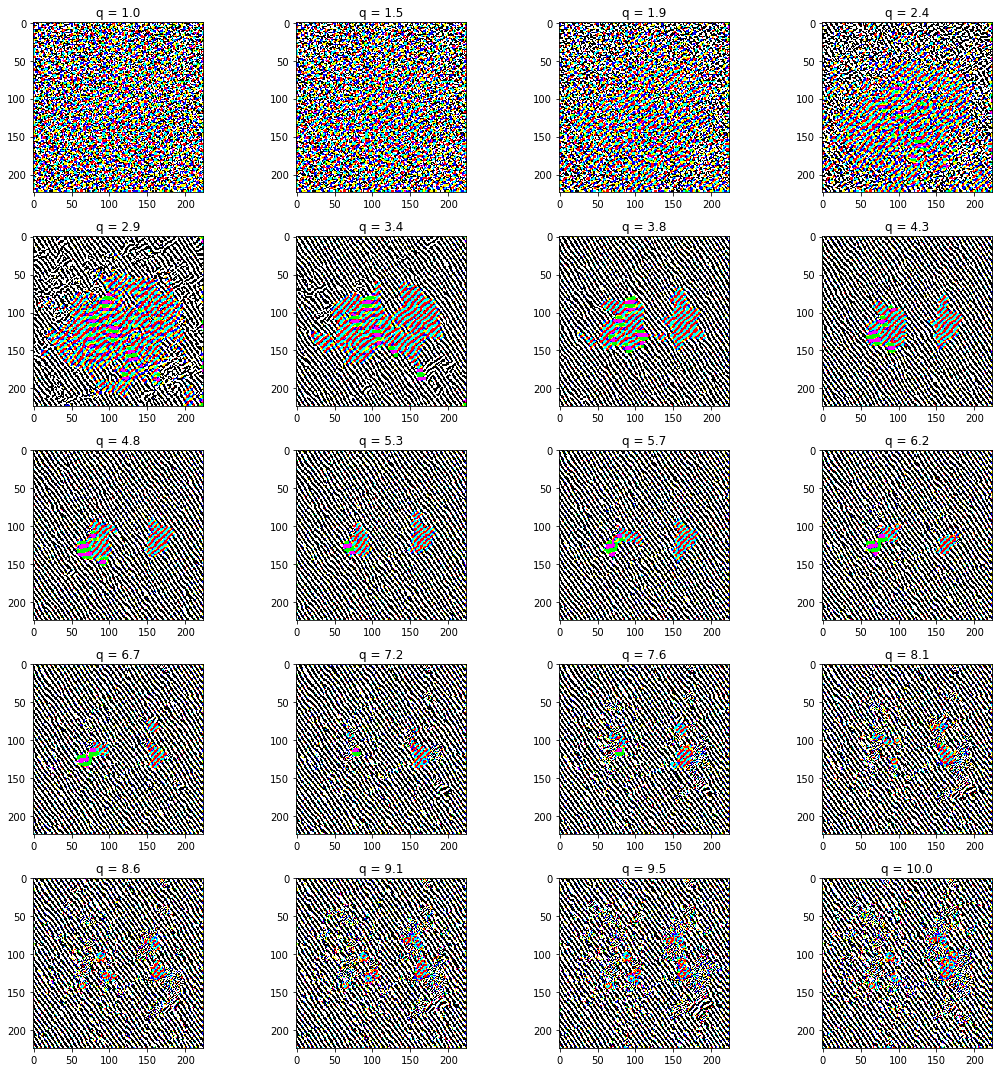

100%|██████████| 391/391 [14:07<00:00,  2.02s/it]


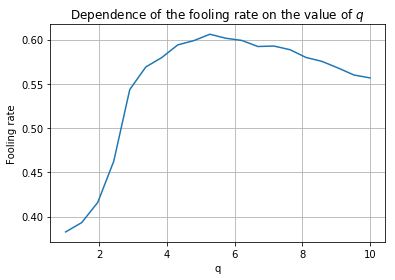

In [12]:
d = torch.device('cuda')
path = 'exp_6.3/vgg19/'
make_exp(net_type='vgg19', device=d, layer_num=10, path=path)

# VGG16 block2_pool

100%|██████████| 20/20 [43:51<00:00, 120.79s/it]


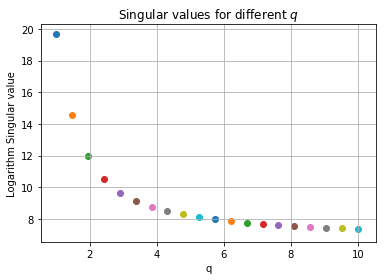

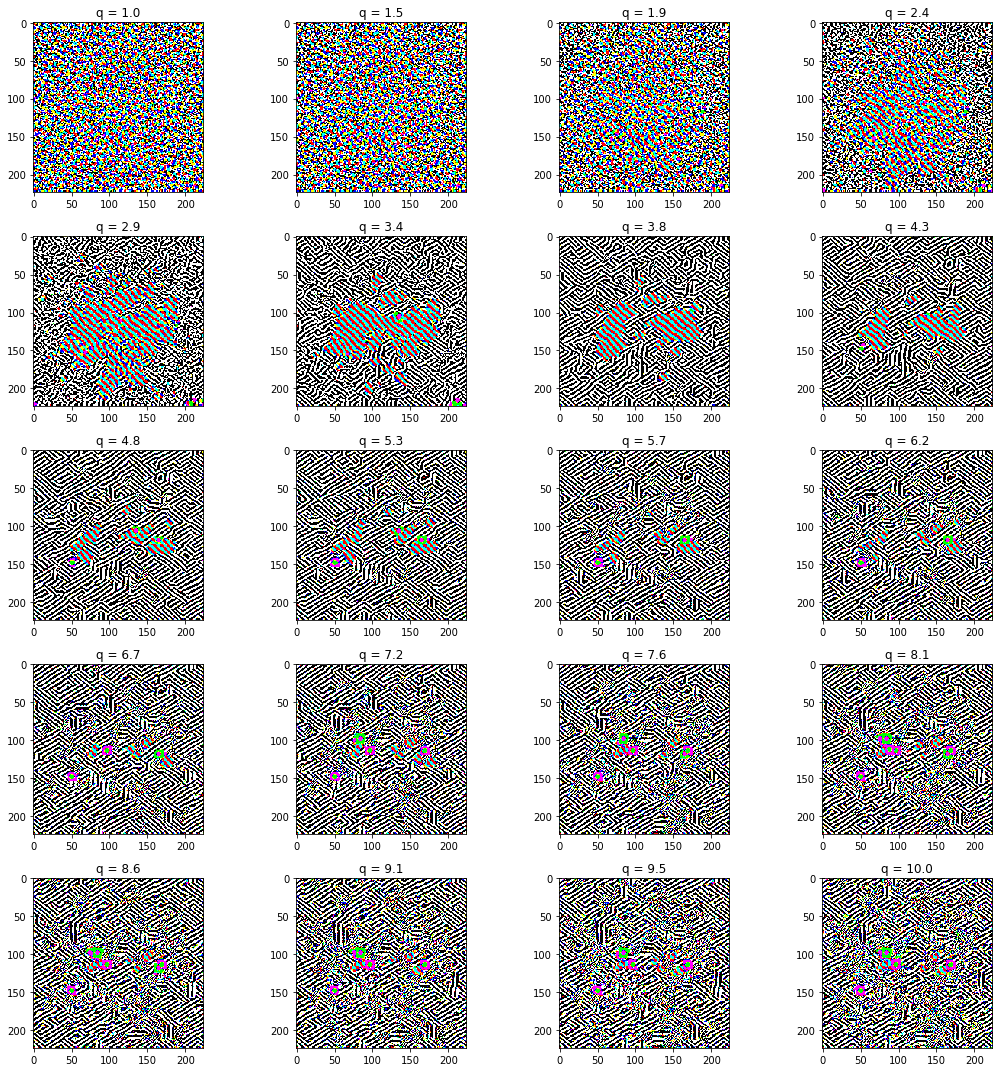

100%|██████████| 391/391 [11:40<00:00,  1.57s/it]


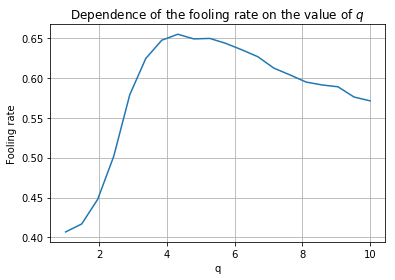

In [12]:
d = torch.device('cuda')
path = 'exp_6.3/vgg16/'
make_exp(net_type='vgg16', device=d, layer_num=10, path=path)

# ResNet 50 conv1

100%|██████████| 20/20 [43:44<00:00, 136.19s/it]


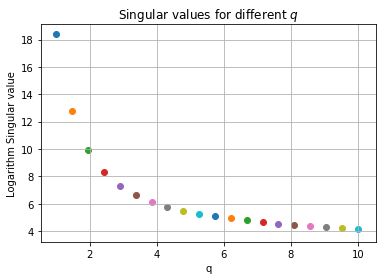

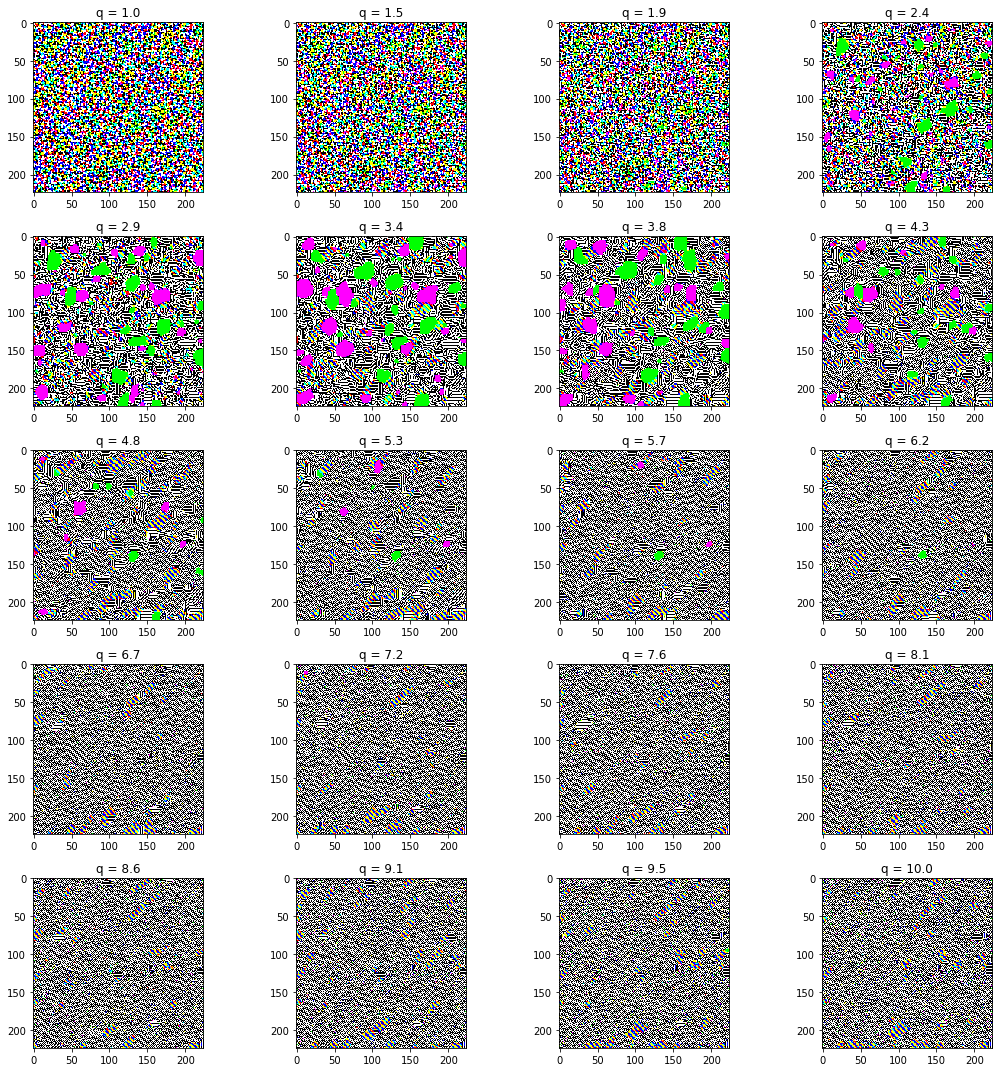

 92%|█████████▏| 359/391 [09:11<00:49,  1.56s/it]

In [ ]:
d = torch.device('cuda')
path = 'exp_6.3/resnet50/'
make_exp(net_type='resnet50', device=d, layer_num=1, path=path)